# Analyse de densité de trafic et identification des zones de congestion

/tmp/ipykernel_15804/3004350846.py:41: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()  # Heure actuelle en UTC
/tmp/ipykernel_15804/3004350846.py:55: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  print(f"[{datetime.utcfromtimestamp(timestamp)}] Zone {zone['name']}: {num_aircraft} avions détectés")


[2025-03-18 05:36:01] Zone Paris: 43 avions détectés
[2025-03-18 05:36:01] Zone London: 60 avions détectés
[2025-03-18 05:36:01] Zone Frankfurt: 27 avions détectés
[2025-03-18 05:36:01] Zone Madrid: 19 avions détectés
[2025-03-18 05:36:01] Zone Rome: 11 avions détectés
[2025-03-18 05:51:01] Zone Paris: 43 avions détectés
[2025-03-18 05:51:01] Zone London: 60 avions détectés
[2025-03-18 05:51:01] Zone Frankfurt: 27 avions détectés
[2025-03-18 05:51:01] Zone Madrid: 19 avions détectés
[2025-03-18 05:51:01] Zone Rome: 11 avions détectés
[2025-03-18 06:06:01] Zone Paris: 43 avions détectés
[2025-03-18 06:06:01] Zone London: 62 avions détectés
[2025-03-18 06:06:01] Zone Frankfurt: 28 avions détectés
[2025-03-18 06:06:01] Zone Madrid: 18 avions détectés
[2025-03-18 06:06:01] Zone Rome: 12 avions détectés
[2025-03-18 06:21:01] Zone Paris: 43 avions détectés
[2025-03-18 06:21:01] Zone London: 62 avions détectés
[2025-03-18 06:21:01] Zone Frankfurt: 26 avions détectés
[2025-03-18 06:21:01] Zone

/tmp/ipykernel_15804/3004350846.py:67: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "datetime": datetime.utcfromtimestamp(entry["timestamp"]),
/tmp/ipykernel_15804/3004350846.py:77: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  eight_hours_ago = datetime.utcnow() - timedelta(hours=8)


📊 Heures de pointe par zone:
         zone  hour  avg_traffic
0   Frankfurt     6        27.25
1   Frankfurt     5        27.00
2   Frankfurt     7        27.00
3   Frankfurt    11        25.00
4   Frankfurt     8        24.25
5   Frankfurt     9        22.25
6   Frankfurt    10        21.50
7      London    11        67.00
8      London    10        63.75
9      London     8        63.25
10     London     7        63.00
11     London     6        62.00
12     London     9        61.50
13     London     5        60.00
14     Madrid    11        24.00
15     Madrid     9        23.25
16     Madrid    10        23.25
17     Madrid     8        21.75
18     Madrid     7        21.00
19     Madrid     6        19.25
20     Madrid     5        19.00
21      Paris     9        46.25
22      Paris    11        46.00
23      Paris     7        45.75
24      Paris     8        45.75
25      Paris    10        45.50
26      Paris     6        43.25
27      Paris     5        43.00
28       Rome 

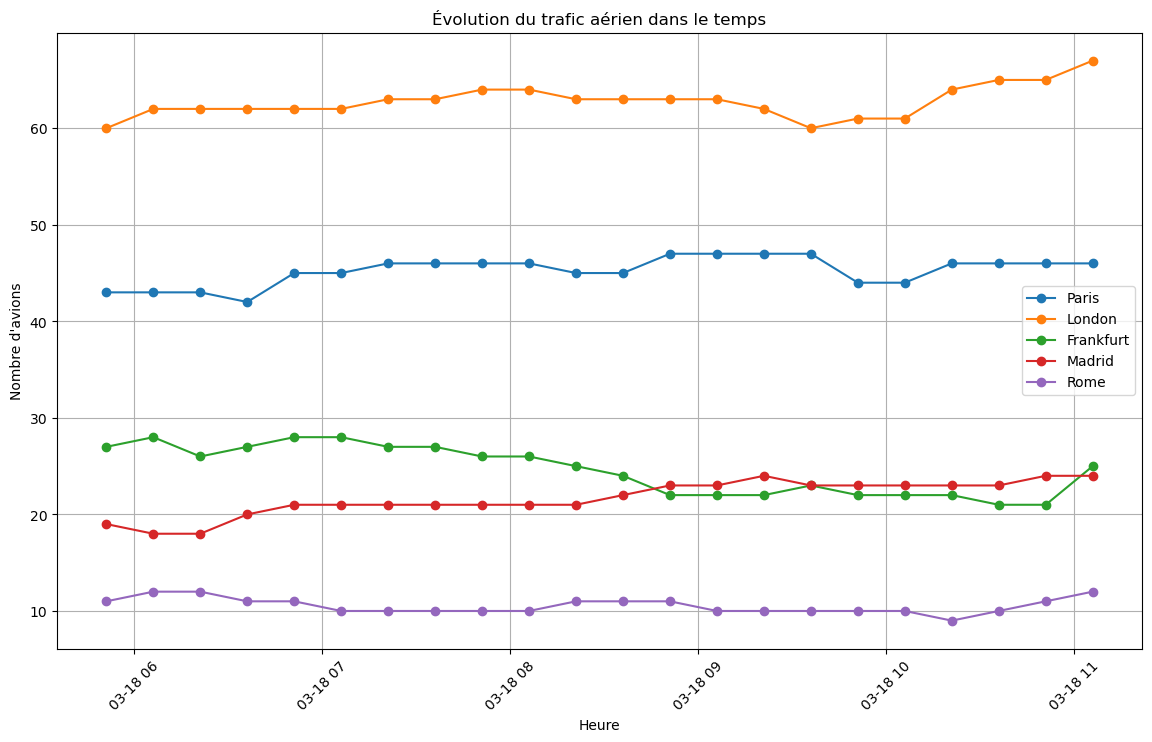

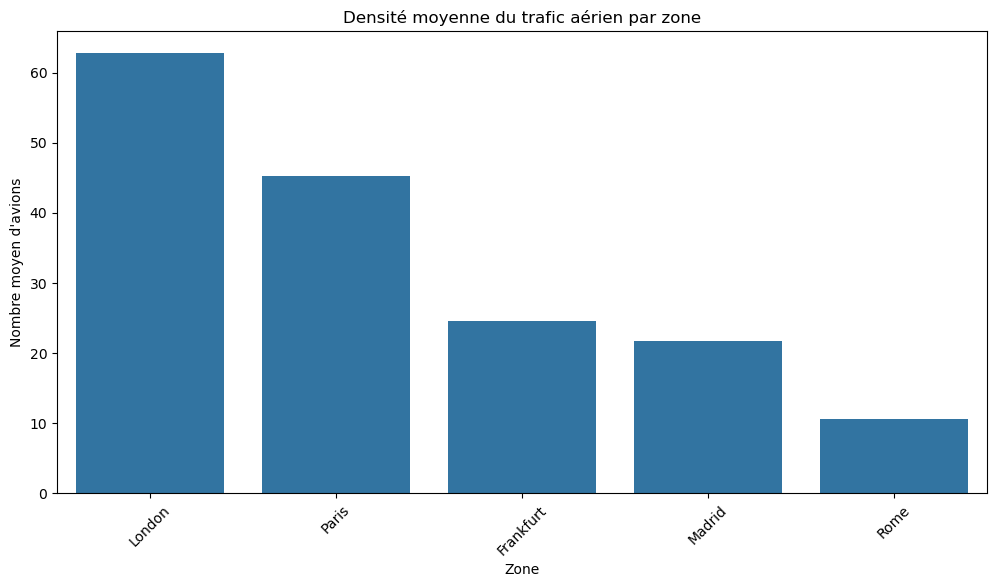

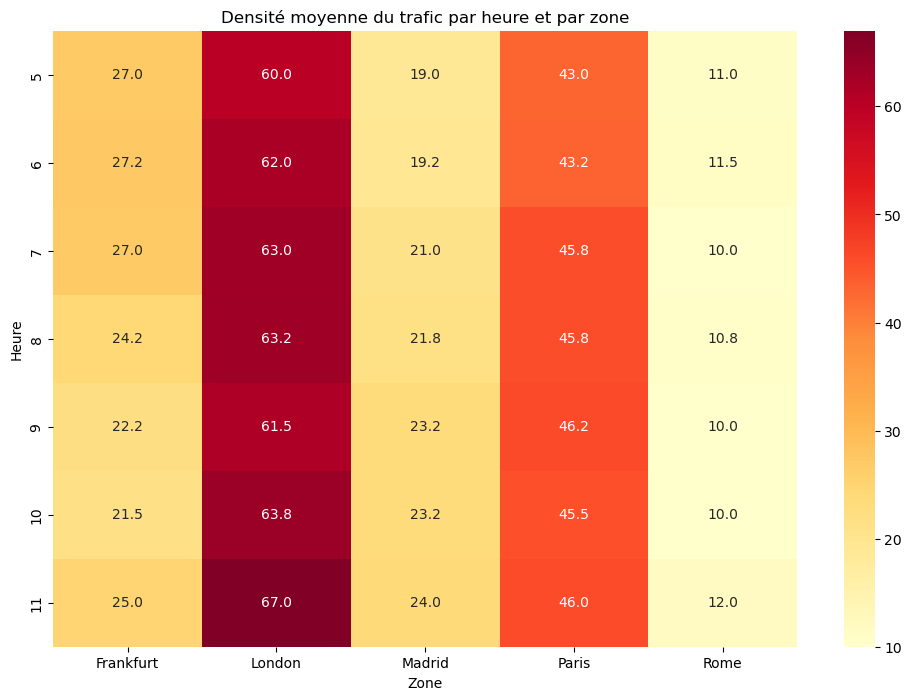

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, lit, count
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta

# ========================== Initialisation Spark ========================== #
spark = SparkSession.builder \
    .appName("AirTrafficDensity") \
    .config("spark.sql.session.timeZone", "UTC") \
    .getOrCreate()

# ========================== Définition des Zones ========================== #
zones = [
    {"name": "Paris", "lamin": 48.5, "lamax": 49.5, "lomin": 1.5, "lomax": 3.0},
    {"name": "London", "lamin": 51.0, "lamax": 52.0, "lomin": -1.0, "lomax": 0.5},
    {"name": "Frankfurt", "lamin": 49.5, "lamax": 50.5, "lomin": 8.0, "lomax": 9.0},
    {"name": "Madrid", "lamin": 40.0, "lamax": 41.0, "lomin": -4.0, "lomax": -3.0},
    {"name": "Rome", "lamin": 41.5, "lamax": 42.5, "lomin": 12.0, "lomax": 13.0}
]

# ========================== Fonction pour récupérer les données ========================== #
def fetch_traffic_data(lamin, lamax, lomin, lomax):
    """Récupère les données de trafic aérien depuis OpenSky"""
    url = "https://opensky-network.org/api/states/all"
    params = {"lamin": lamin, "lamax": lamax, "lomin": lomin, "lomax": lomax}
    response = requests.get(url, params=params)
    
    if response.status_code != 200:
        return None
    return response.json()

# ========================== Récupérer les 8 heures passées ========================== #
def fetch_past_traffic_data(zones, interval_minutes=15):
    """Récupère les données des 8 dernières heures à intervalles de 15 minutes"""
    all_data = []
    
    end_time = datetime.utcnow()  # Heure actuelle en UTC
    start_time = end_time - timedelta(hours=8)  # 8 heures avant
    
    timestamps = [int((start_time + timedelta(minutes=i)).timestamp()) for i in range(0, 8 * 60, interval_minutes)]
    
    for timestamp in timestamps:
        for zone in zones:
            data = fetch_traffic_data(zone["lamin"], zone["lamax"], zone["lomin"], zone["lomax"])
            
            if data and 'states' in data and data['states']:
                num_aircraft = len(data['states'])
                entry = {"timestamp": timestamp, "zone": zone["name"], "aircraft_count": num_aircraft}
                all_data.append(entry)
                
                print(f"[{datetime.utcfromtimestamp(timestamp)}] Zone {zone['name']}: {num_aircraft} avions détectés")
            
            time.sleep(2)  # Pause pour éviter de surcharger l'API
    
    return all_data

# ========================== Traitement des données avec Spark ========================== #
def process_density_data(density_data):
    """Charge et filtre les données dans Spark pour ne garder que les 8 dernières heures"""
    processed_data = [
        {
            "timestamp": entry["timestamp"],
            "datetime": datetime.utcfromtimestamp(entry["timestamp"]),
            "zone": entry["zone"],
            "aircraft_count": entry["aircraft_count"]
        }
        for entry in density_data
    ]
    
    df = spark.createDataFrame(processed_data)
    
    # Filtrer les données des 8 dernières heures
    eight_hours_ago = datetime.utcnow() - timedelta(hours=8)
    df = df.filter(col("datetime") >= lit(eight_hours_ago))
    
    return df

# ========================== Analyse et Visualisation ========================== #
def analyze_density(df):
    """Génère des visualisations sur le trafic aérien"""
    pd_df = df.toPandas()
    
    # Évolution du trafic dans le temps
    plt.figure(figsize=(14, 8))
    for zone in pd_df["zone"].unique():
        zone_data = pd_df[pd_df["zone"] == zone]
        plt.plot(zone_data["datetime"], zone_data["aircraft_count"], marker='o', linestyle='-', label=zone)
    
    plt.title("Évolution du trafic aérien dans le temps")
    plt.xlabel("Heure")
    plt.ylabel("Nombre d'avions")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig("evolution_trafic.png")

    # Densité moyenne par zone
    plt.figure(figsize=(12, 6))
    avg_density = pd_df.groupby("zone")["aircraft_count"].mean().sort_values(ascending=False)
    sns.barplot(x=avg_density.index, y=avg_density.values)
    plt.title("Densité moyenne du trafic aérien par zone")
    plt.xlabel("Zone")
    plt.ylabel("Nombre moyen d'avions")
    plt.xticks(rotation=45)
    plt.savefig("densite_moyenne.png")

    # Matrice de chaleur du trafic
    pivot_df = pd_df.pivot_table(index=pd_df["datetime"].dt.hour, columns="zone", values="aircraft_count", aggfunc="mean").fillna(0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap="YlOrRd", fmt=".1f")
    plt.title("Densité moyenne du trafic par heure et par zone")
    plt.xlabel("Zone")
    plt.ylabel("Heure")
    plt.savefig("heatmap_densite.png")
    
    return pd_df

# ========================== Statistiques ========================== #
def calculate_statistics(df):
    """Calcule les statistiques du trafic aérien"""
    df.createOrReplaceTempView("air_traffic")
    
    # Heures de pointe
    peak_hours = spark.sql("""
        SELECT zone, hour(datetime) as hour, AVG(aircraft_count) as avg_traffic
        FROM air_traffic
        GROUP BY zone, hour
        ORDER BY zone, avg_traffic DESC
    """)
    
    # Zone la plus congestionnée
    most_congested = spark.sql("""
        SELECT zone, MAX(aircraft_count) as max_aircraft, AVG(aircraft_count) as avg_aircraft
        FROM air_traffic
        GROUP BY zone
        ORDER BY max_aircraft DESC
        LIMIT 1
    """)
    
    return {"peak_hours": peak_hours.toPandas(), "most_congested": most_congested.toPandas()}

# ========================== Exécution ========================== #
if __name__ == "__main__":
    # Récupération des données des 8 dernières heures
    density_data = fetch_past_traffic_data(zones, interval_minutes=15)
    
    # Traitement des données avec Spark
    density_df = process_density_data(density_data)
    
    # Analyse et visualisation
    pd_density = analyze_density(density_df)
    
    # Calcul des statistiques
    stats = calculate_statistics(density_df)

    print("📊 Heures de pointe par zone:")
    print(stats["peak_hours"])
    
    print("\n🔥 Zone la plus congestionnée:")
    print(stats["most_congested"])

    # Arrêter Spark
    spark.stop()
